# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
# Under Linux
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64', seed=123)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.51024199 -1.5
 -0.          0.          6.80061245  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

```
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
 ```

When finished, you can close the environment.

`env.close()`

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 5. Competing multi-agents as multiple non-competing agents

In [5]:
# Utilities functions
def unity_step_wrap(actions):
    """Unity Environment action wrapper
    
    Params
    ======
        action (int): action to take
     
    Return
    ======
        OpenAI-like action outcome (tuple): bundled (next_state, reward, done)
    """
    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_states = env_info.vector_observations      # get the next state
    rewards = env_info.rewards                      # get the reward
    dones = env_info.local_done                     # see if episode has finished
    return (next_states, rewards, dones)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_scores(scores, smooth_window=100):
    scores_smoothed = moving_average(scores, smooth_window)
    # plot the scores
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, linewidth=1, alpha=0.4, color='steelblue')
    plt.plot(np.arange(len(scores))[smooth_window-1:,], scores_smoothed, linewidth=1.5, alpha=1, color='firebrick')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    return fig

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return (checkpoint['actor'], checkpoint['critic'], checkpoint['scores'])

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [7]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100, learn_every=5, min_noise=0.02, solved_score = 0.5, name="default"):
    scores_deque = deque(maxlen=print_every)
    scores = []
    noise = 1.0
    min_noise = min_noise
    noise_reduction = min_noise**(1/n_episodes) # Reaches min_noise after n_episodes with exponential decrease
      
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                     
        
        agent.reset()
        scores_episode = np.zeros(num_agents)
        noise *= noise_reduction
        
        for t in range(max_t):
            actions = agent.act(states, noise=max(noise, min_noise))
            next_states, rewards, dones = unity_step_wrap(actions)
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.save_experience(state, action, reward, next_state, done)
                
            scores_episode += rewards
            states = next_states                                
                       
            if t % learn_every == 0:
                agent.step()
            
            if np.any(dones):
                break 
        
        score = np.max(scores_episode)
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
    
        # Save checkpoint
        checkpoint = {
            'actor': agent.actor_local.state_dict(),
            'critic': agent.critic_local.state_dict(),
            'scores': scores
        }
        torch.save(checkpoint, 'saved-checkpoints/checkpoint-' + name + '.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > solved_score:
            break
        
    return scores

* **Solving the environment**

In [8]:
scores = ddpg(n_episodes=10000, min_noise=0.02, learn_every=5, name='solved')

Episode 100	Average Score: 0.03
Episode 200	Average Score: 0.03
Episode 300	Average Score: 0.05
Episode 400	Average Score: 0.07
Episode 500	Average Score: 0.04
Episode 600	Average Score: 0.06
Episode 700	Average Score: 0.08
Episode 800	Average Score: 0.08
Episode 900	Average Score: 0.06
Episode 1000	Average Score: 0.11
Episode 1100	Average Score: 0.13
Episode 1180	Average Score: 0.52

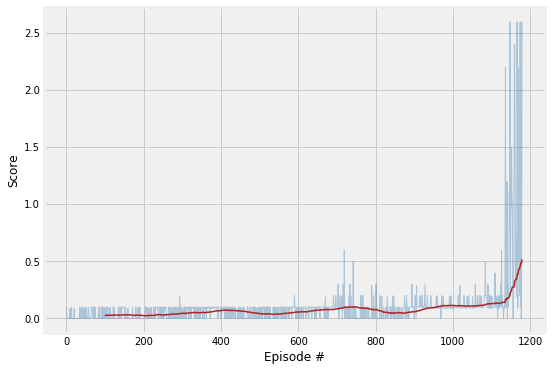

In [5]:
_, _, scores_solved = load_checkpoint('saved-checkpoints/checkpoint-solved.pth')
figure = plot_scores(scores_solved)

* **Monitoring beyond solving scores in the long run**

In [8]:
scores = ddpg(n_episodes=10000, min_noise=0.01, learn_every=5, solved_score = 99, name='in-the-long-run')

Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.03
Episode 400	Average Score: 0.05
Episode 500	Average Score: 0.04
Episode 600	Average Score: 0.06
Episode 700	Average Score: 0.06
Episode 800	Average Score: 0.08
Episode 900	Average Score: 0.07
Episode 1000	Average Score: 0.13
Episode 1100	Average Score: 0.17
Episode 1200	Average Score: 0.71
Episode 1300	Average Score: 0.54
Episode 1400	Average Score: 0.57
Episode 1500	Average Score: 0.25
Episode 1600	Average Score: 0.27
Episode 1700	Average Score: 0.27
Episode 1800	Average Score: 0.24
Episode 1900	Average Score: 0.19
Episode 2000	Average Score: 0.12
Episode 2100	Average Score: 0.14
Episode 2200	Average Score: 0.12
Episode 2300	Average Score: 0.07
Episode 2400	Average Score: 0.07
Episode 2500	Average Score: 0.06
Episode 2600	Average Score: 0.06
Episode 2700	Average Score: 0.04
Episode 2800	Average Score: 0.04
Episode 2900	Average Score: 0.05
Episode 3000	Average Score: 0.04
Episode 3100	Averag

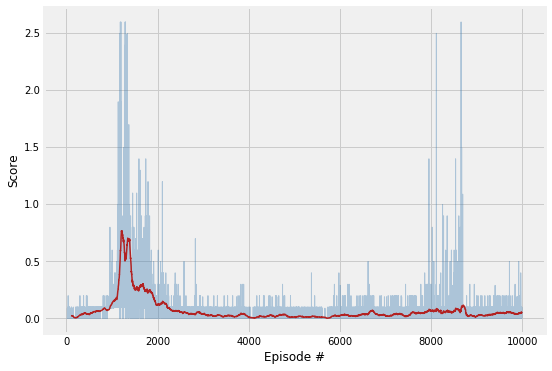

In [9]:
_, _, scores_long_run = load_checkpoint('saved-checkpoints/checkpoint-in-the-long-run.pth')
figure = plot_scores(scores_long_run)

* **Watching solved environment agent in action**

In [7]:
# Reloading networks weights
actor_weights, critic_weights, scores_solved = load_checkpoint('saved-checkpoints/checkpoint-solved.pth')

# Instantiating the agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)
agent.actor_local.load_state_dict(actor_weights)
agent.critic_local.load_state_dict(critic_weights)

In [ ]:
# Agent acting over 30 episodes
for i in range(1, 30):                                     # play game for 30 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.5000000074505806
Score (max over agents) from episode 2: 0.5900000091642141
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.20000000298023224
